# Credit Card Fraud Detection

In [53]:
#!pip install tensorflow==2.8.0

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

### Load Data

In [55]:
train = pd.read_csv('data/creditcard_train.csv')
test = pd.read_csv('data/creditcard_test.csv')

In [56]:
train.head(3)

,ID,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,149357,91075,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,...,-0.095308,0.946629,-0.297403,-0.368344,0.198731,-0.078591,0.366709,0.073767,38.76,1
1,47802,43369,-3.365319,2.426503,-3.752227,0.276017,-2.305870,-1.961578,-3.029283,-1.674462,...,2.070008,-0.512626,-0.248502,0.126550,0.104166,-1.055997,-1.200165,-1.012066,88.00,1
2,149145,90676,-2.405580,3.738235,-2.317843,1.367442,0.394001,1.919938,-3.106942,-10.764403,...,10.005998,-2.454964,1.684957,0.118263,-1.531380,-0.695308,-0.152502,-0.138866,6.99,1


In [57]:
test.head(3)

,ID,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,10,10,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,...,-0.387226,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80
2,17,13,-0.436905,0.918966,0.924591,-0.727219,0.915679,-0.127867,0.707642,0.087962,...,-0.047021,-0.194796,-0.672638,-0.156858,-0.888386,-0.342413,-0.049027,0.079692,0.131024,0.89


### Split dataset into train and test 

In [58]:
fraud = train[train.Class == 1]
normal = train[train.Class == 0]

print(normal['Amount'].describe(), fraud['Amount'].describe())

count    255884.000000
mean         88.281114
std         251.248123
min           0.000000
25%           5.670000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64 count     443.000000
mean      118.634041
std       253.107901
min         0.000000
25%         1.000000
50%         9.210000
75%       104.030000
max      2125.870000
Name: Amount, dtype: float64


Find difference between 2 files

This Dataset is highly imbalanced dataset.  
( fraud = > 443 / normal ==> 255884 )

Selecting amount 2 Techniques : Undersampling or Oversampling

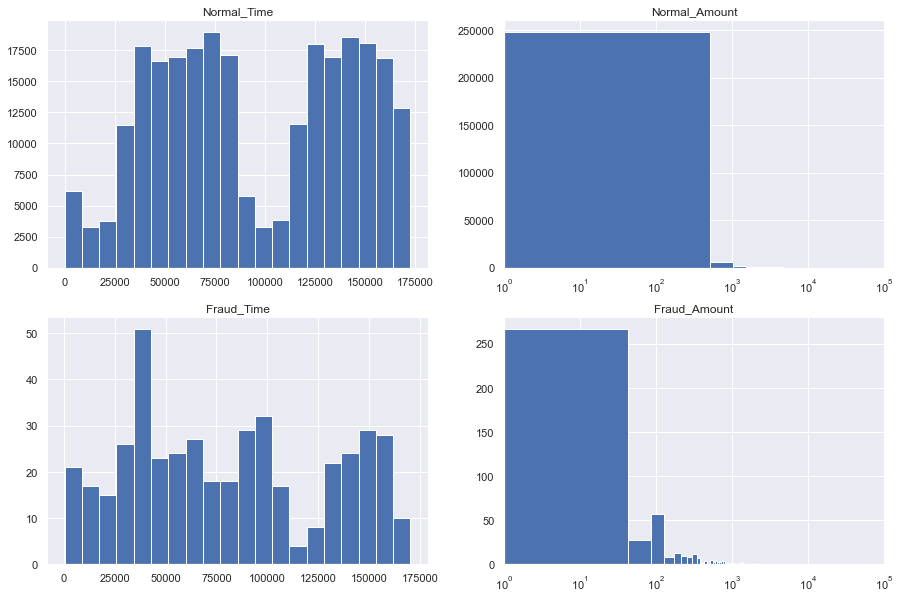

In [59]:

import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches(15, 10)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Normal_Time')
ax1.hist(normal['Time'], bins=20)
ax2.set_title('Normal_Amount')
ax2.hist(normal['Amount'], bins=50)
ax2.set_xscale('log')
ax2.set_xticks([1, 10, 100, 1000, 10000, 100000])

ax3.set_title('Fraud_Time')
ax3.hist(fraud['Time'], bins=20)
ax4.set_title('Fraud_Amount')
ax4.hist(fraud['Amount'], bins=50)
ax4.set_xscale('log')
ax4.set_xticks([1, 10, 100, 1000, 10000, 100000])


In [60]:
# Use `shuffle` function from sklearn.utils
# Shuffling the sorted data can increase performances of model
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

X_train = shuffle(train, random_state=0)
X_test = test

Y_train = X_train[['Class']]
X_train = X_train.drop('Class', axis=1)

# resample using SMOTE
smote = SMOTE(k_neighbors=5)
X_samp, Y_samp = smote.fit_resample(X_train, Y_train)
train_resample = pd.concat([X_samp, Y_samp], axis=1)

# Re-shuffle the new datasets (resample)
X_train = shuffle(train_resample, random_state=0)

# Re-split the x, y
Y_train = X_train[['Class']]
X_train = X_train.drop('Class', axis=1)

In [61]:
# Y_TRAIN -> Category Data Type
y_train = Y_train.values.astype('float')
y_train = np.stack([1 - y_train, y_train]).T
y_train = y_train.reshape(-1, 2)

### Normalize data

In [62]:
# scale all feature in the Train dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
np.shape(X_train), np.shape(y_train)

((511768, 31), (511768, 2))

### Define the model

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import Recall
from keras.metrics import Precision

In [71]:
def create_mlp(pkeep=0.5):
    '''
    input: pkeep (dropout rate)
    return: model
    '''
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(31,)),
        tf.keras.layers.Dense(64, activation='ReLU'),
        tf.keras.layers.Dense(32, activation='ReLU'),
        tf.keras.layers.Dense(16, activation='ReLU'),
        tf.keras.layers.Dropout(pkeep),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model

### Train the model

In [72]:
model = create_mlp()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                2048      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 2)                 34        
                                                                 
Total params: 4,690
Trainable params: 4,690
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Set loss function and optimizer and add Accuracy metric
# Set hyperparameters (batch size, ...)
# Train the model

metrics = [tf.keras.metrics.Accuracy(name='Accuracy'),
        tf.keras.metrics.FalseNegatives(name='FN'),
        tf.keras.metrics.FalsePositives(name='FP'),
        tf.keras.metrics.TrueNegatives(name='TN'),
        tf.keras.metrics.TruePositives(name='TP'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
]

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=metrics)
model.fit(X_train, y_train, batch_size=500, epochs=100, validation_split=0.2)


Epoch 1/100
819/819 [==============================] - 11s 10ms/step - loss: 0.0365 - Accuracy: 0.2537 - FN: 4642.0000 - FP: 4642.0000 - TN: 404772.0000 - TP: 404772.0000 - precision: 0.9887 - recall: 0.9887 - val_loss: 0.0095 - val_Accuracy: 0.3290 - val_FN: 307.0000 - val_FP: 307.0000 - val_TN: 102047.0000 - val_TP: 102047.0000 - val_precision: 0.9970 - val_recall: 0.9970
Epoch 2/100
819/819 [==============================] - 7s 8ms/step - loss: 0.0139 - Accuracy: 0.3686 - FN: 1506.0000 - FP: 1506.0000 - TN: 407908.0000 - TP: 407908.0000 - precision: 0.9963 - recall: 0.9963 - val_loss: 0.0096 - val_Accuracy: 0.4455 - val_FN: 256.0000 - val_FP: 256.0000 - val_TN: 102098.0000 - val_TP: 102098.0000 - val_precision: 0.9975 - val_recall: 0.9975
Epoch 3/100
819/819 [==============================] - 7s 9ms/step - loss: 0.0140 - Accuracy: 0.3904 - FN: 1449.0000 - FP: 1449.0000 - TN: 407965.0000 - TP: 407965.0000 - precision: 0.9965 - recall: 0.9965 - val_loss: 0.0045 - val_Accuracy: 0.4398 

### Evaluate the model with other metrics

In [67]:
model.history.history.keys()

dict_keys(['loss', 'Accuracy', 'FN', 'FP', 'TN', 'TP', 'precision', 'recall', 'val_loss', 'val_Accuracy', 'val_FN', 'val_FP', 'val_TN', 'val_TP', 'val_precision', 'val_recall'])

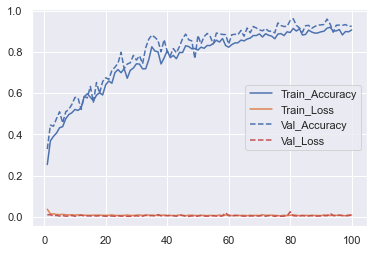

In [74]:
plt.plot(range(1, 101), model.history.history['Accuracy'], label='Train_Accuracy')
plt.plot(range(1, 101), model.history.history['loss'], label='Train_Loss')
plt.plot(range(1, 101), model.history.history['val_Accuracy'], label='Val_Accuracy', color='b', ls='--')
plt.plot(range(1, 101), model.history.history['val_loss'], label='Val_Loss', color='r',ls='--')
plt.legend()

In [48]:
# Recall = 맞춘 정답 / 실제 정답
# Precision = 실제 정답 개수 / 정답 판정 숫자

KeyError: 'Accuracy'

In [76]:
test

,ID,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,10,10,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,...,-0.387226,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80
2,17,13,-0.436905,0.918966,0.924591,-0.727219,0.915679,-0.127867,0.707642,0.087962,...,-0.047021,-0.194796,-0.672638,-0.156858,-0.888386,-0.342413,-0.049027,0.079692,0.131024,0.89
3,39,29,1.110880,0.168717,0.517144,1.325407,-0.191573,0.019504,-0.031849,0.117620,...,-0.190120,-0.037709,0.095701,-0.048198,0.232115,0.606201,-0.342097,0.036770,0.007480,6.54
4,40,32,1.249055,-0.624727,-0.710589,-0.991600,1.429973,3.692977,-1.090209,0.967291,...,0.097853,-0.006293,0.009200,-0.129463,1.112970,0.500382,1.196549,-0.048220,0.005094,29.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28475,284740,172733,-0.846934,0.045459,2.160620,-1.935812,-1.864416,-0.939825,-0.972629,0.600049,...,-0.000469,0.561532,1.556393,-0.021918,0.947182,-0.506350,-0.254708,0.304011,0.166451,11.99
28476,284747,172735,-1.709478,2.065189,-0.655055,-0.961338,-0.209548,-1.003243,0.503629,0.431431,...,0.606405,-0.347220,-0.601463,0.195967,0.040851,-0.203402,0.145430,0.742064,0.415195,9.42
28477,284756,172745,1.818907,-0.299814,-0.252033,1.519449,-0.447282,-0.009204,-0.322293,0.134432,...,-0.245487,-0.445671,-1.089085,0.419367,-0.071000,-0.393281,-1.127292,0.047299,-0.035322,37.36
28478,284758,172745,1.911377,1.220896,-1.665127,4.148798,1.029442,-0.727610,0.500745,-0.198614,...,-0.185466,-0.429116,-1.184198,0.288661,-0.418323,-0.222729,-0.335830,-0.001158,0.017556,6.75


In [77]:
pred = model.predict(X_test)
pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [78]:
df1 = pd.DataFrame(columns=['Class'])
df1['Class'] = pred[:, 1]
df1['Class'] = round(df1['Class'])
df1['Class'] = df1['Class'].astype(int)
print(df1.groupby(['Class']).agg({'Class':'count'}))
test = pd.concat([test, df1], axis=1)

       Class
Class       
0      28415
1         65


In [79]:
test_fraud = test[test.Class==1]
test_normal = test[test.Class==0]

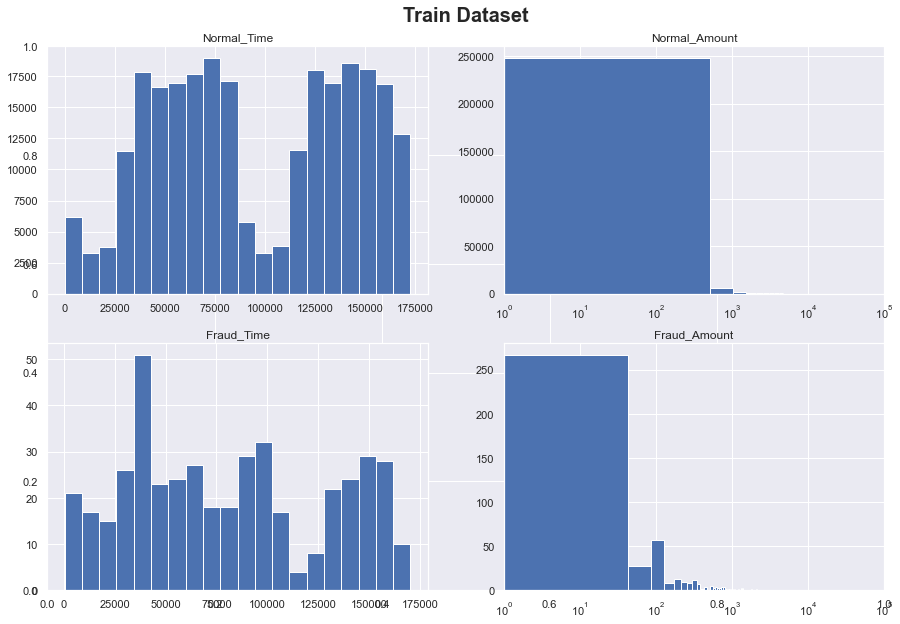

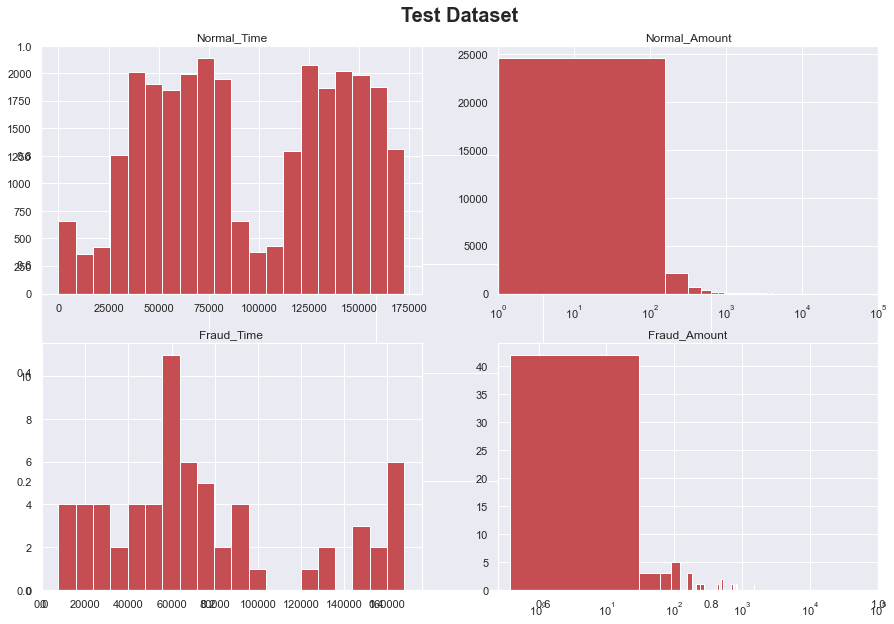

In [80]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.title('Train Dataset', pad=25, fontweight='bold', fontsize=20)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Normal_Time')
ax1.hist(normal['Time'], bins=20)
ax2.set_title('Normal_Amount')
ax2.hist(normal['Amount'], bins=50)
ax2.set_xscale('log')
ax2.set_xticks([1, 10, 100, 1000, 10000, 100000])

ax3.set_title('Fraud_Time')
ax3.hist(fraud['Time'], bins=20)
ax4.set_title('Fraud_Amount')
ax4.hist(fraud['Amount'], bins=50)
ax4.set_xscale('log')
ax4.set_xticks([1, 10, 100, 1000, 10000, 100000])
plt.show()

fig = plt.figure()
fig.set_size_inches(15, 10)
plt.title('Test Dataset', pad=25, fontweight='bold', fontsize=20)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Normal_Time')
ax1.hist(test_normal['Time'], color='r', bins=20)
ax2.set_title('Normal_Amount')
ax2.hist(test_normal['Amount'], color='r', bins=50)
ax2.set_xscale('log')
ax2.set_xticks([1, 10, 100, 1000, 10000, 100000])

ax3.set_title('Fraud_Time')
ax3.hist(test_fraud['Time'], color='r', bins=20)
ax4.set_title('Fraud_Amount')
ax4.hist(test_fraud['Amount'], color='r', bins=50)
ax4.set_xscale('log')
ax4.set_xticks([1, 10, 100, 1000, 10000, 100000])
